# Crossentropy method for Taxi

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [8]:
import os
import gym
import numpy as np
import pandas as pd

env = gym.make("Taxi-v3")
env.reset()assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [9]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


The filled square represents the taxi, which is yellow without a passenger and green with a passenger.
The pipe ("|") represents a wall which the taxi cannot cross.
R, G, Y, B are the possible pickup and destination locations. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.
As verified by the prints, we have an Action Space of size 6 and a State Space of size 500. As you'll see, our RL algorithm won't need any more information than these two things. All we need is a way to identify a state uniquely by assigning a unique number to every possible state, and RL learns to choose an action number from 0-5 where:

0 = south
1 = north
2 = east
3 = west
4 = pickup
5 = dropoff

In [10]:
env.reset()
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)
env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



The Reward Table

When the Taxi environment is created, there is an initial Reward table that's also created, called `P`. We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a states × actions matrix.


Since every state is in this matrix, we can see the default reward values assigned to our illustration's state:
This dictionary has the structure {action: [(probability, nextstate, reward, done)]}.

In [11]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

A few things to note:

The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.
In this env, probability is always 1.0.
The nextstate is the state we would be in if we take the action at this index of the dict
All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)
done is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode
Note that if our agent chose to explore action two (2) in this state it would be going East into a wall. The source code has made it impossible to actually move the taxi across a wall, so if the taxi chooses that action, it will just keep accruing -1 penalties, which affects the long-term reward.

# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [12]:
policy = np.ones(shape=(n_states, n_actions)) * 1. / n_actions

In [14]:
#test policy
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.
Play game until end or for t_max ticks.
    
    param policy: an array of shape [n_states,n_actions] with action probabilities
    returns: list of states, list of actions and sum of rewards
    

In [15]:
def generate_session(policy, t_max=10**4):
    
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        #choose actions randomly
        a = np.random.choice(n_actions,p=policy[s])

        new_s, r, done, info = env.step(a)

        # Record state, action and add up reward to states,actions and total_reward accordingly.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [17]:
#apply policy to generate sessions
s, a, r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float]

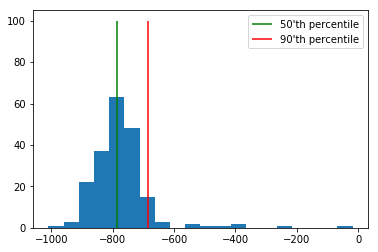

In [20]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Crossentropy method steps
Select states and actions from games that have rewards >= percentile
    
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

Please return elite states and actions in their original order

In [21]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    reward_threshold = np.percentile(rewards_batch,q=percentile)
    elite_states  = [state for i, session in enumerate(states_batch) for state in session if rewards_batch[i] >= reward_threshold]
    elite_actions = [action for i, session in enumerate(actions_batch) for action in session if rewards_batch[i] >= reward_threshold]
    return elite_states, elite_actions

In [22]:
#test function
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_40[1] == [3, 2, 0, 1, 3, 3]),\
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]),\
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]),\
    "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


Update our policy 

based on the elite states and actions selected from elite sessions
Given old policy and a list of elite states/actions from select_elites,
    
    return new updated policy where each action probability is proportional to
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

In [24]:
def update_policy(elite_states, elite_actions):
    new_policy = policy
    for s in np.unique(elite_states):
        occ_state=0
        actions=[]
        for index,state in enumerate(elite_states):
            if s==state :
                occ_state+=1
                actions.append(elite_actions[index])
        new_policy[s]= np.zeros(n_actions)
        for a in np.unique(actions):
            occ_action=actions.count(a)
            new_policy[s,a]=occ_action/occ_state
            
    # Don't forget to set 1/n_actions for all actions in unvisited states.

    return new_policy

In [25]:
#test updated policy
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = update_policy(elite_states, elite_actions)
assert np.isfinite(new_policy).all(
), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(
    axis=-1), 1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those.

In [26]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [27]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions

mean reward = -130.892, threshold=-200.000


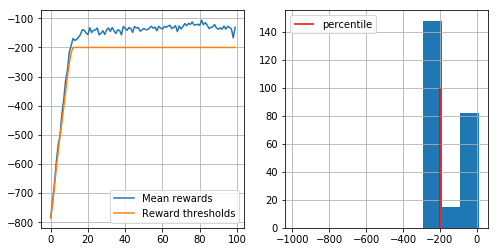

In [28]:
n_sessions = 250  #sample this many sessions
percentile = 50  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch,
                                                rewards_batch,percentile)
    
    new_policy = update_policy(elite_states, elite_actions)
    
    policy = learning_rate*new_policy + (1-learning_rate)*policy
    
    #display results on chart
    show_progress(rewards_batch,log, percentile)